**BrainStation Capstone Project**

**Author: Lynn Ho**

# **Crafting the Perfect Beer:** Predicting Beer Ratings with Sentiment Analysis and Clustering

## Part III: K-Means Clustering

---

## Introduction

This notebook does not require a boosting environment and can be run on a standard Python kernel.

Now that I have looked at supervised learning techniques to predict a beer rating, I want to use K-Means Clustering, an unsupervised learning technique, to see if we can uncover any similar groups or patterns in the text reviews that have yet to be seen. Unlike Logistic Regression, Decision Tree, and XGBoost where we try to optimize the models against specific metrics, we are looking for consistencies with clustering that tell us if the patterns found in the data are sound.  

The technique that I will use is the K-Means Clustering algorithm. K-Means is one of the most commonly used clustering algorithm and works well on large data sets compared to other clustering techniques. Because our data is quite large and analysis on it takes a long time to run on my local machine, I will use the optimized version of K-Means to speed up the computation time.

For the K-Means Clustering model, since I am only interested in the text reviews, I will not include the other columns that describe the ratings, review date, beer category, beer availability, abv, and brewery type.

It should also be noted that scaling is usually required with K-Means Clustering since it is a distance based model, but because I used a TF-IDF Vectorizer on the text reviews, all of the values are between 0 and 1, which means they are already on the same scale. Therefore, I will not be using a scaler on the dataset.

---

## Data Preprocessing

Before clustering can begin, I need to first import the tools that will be used.

In [1]:
# trinity 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scaler
from sklearn.preprocessing import MinMaxScaler

# k-means clustering
from sklearn.cluster import KMeans, MiniBatchKMeans

# silhouette score & silhouette samples
from sklearn.metrics import silhouette_score, silhouette_samples

Now I need to read in the data. This will be the same file that was used in the `beer_classification` notebook and can be found <a href="https://drive.google.com/file/d/105_ToiDUQCiGLWTjEPsimHPx7SrnPB1I/view?usp=sharing">here</a>.

In [2]:
# read in data

sample_df = pd.read_csv('data/beer_sample_cleaned.csv')

In [3]:
# show first few rows

pd.options.display.max_columns=200
sample_df.head()

,look,smell,taste,feel,overall,score,year,month,weekday,abv,retired,Beer-to-go,Brewery,Eatery,Homebrew,Bar,Fall,Limited (brewed once),Rotating,Summer,Winter,Year-round,IPA,bock,brown ale,dark ale,dark lager,pale ale,pale lager,porter,specialty,stout,strong ale,wheat,wild/sour,aaroma,abbey,able,abound,abrasive,absent,absolute,absolutely,absurd,abundance,abundant,abv.1,abyss,accent,accented,accentuate,acceptable,access,accessible,accompanied,accompany,accompanying,according,account,acetic,achieve,acid,acidic,acidity,acquired,acre,acrid,across,act,action,active,actual,actually,adam,add,added,adding,addition,additional,additive,adequate,adequately,adjunct,admit,admittedly,advertised,advocate,affair,affordable,aforementioned,afternoon,aftertaste,afterthought,afterwards,age,aged,aggressive,aggressively,aging,ago,...,whoa,whole,wicked,wide,width,wife,wild,wildflower,willi,willing,win,window,wine,winelike,winey,wing,winner,winter,wisconsin,wise,wish,wisp,wispy,wit,witbier,within,without,wonder,wonderful,wonderfully,wondering,wont,won’t,wood,woodiness,woodsy,woody,woodychandler,word,work,worked,working,world,worldclass,worried,worse,worst,worth,worthy,would,wouldnt,wouldn’t,wouldve,wow,wrap,wrapped,write,writing,written,wrong,x,ya,yarchives,yard,yeah,year.1,yeast,yeastiness,yeastoak,yeasty,yellow,yellowgold,yellowish,yelloworange,yep,yes,yesterday,yet,yield,yielded,ymmv,yogurt,york,youd,youll,young,youre,youve,you’re,yuengling,yum,yummy,yuzu,zero,zest,zesty,zing,zip,zippy,zone
0,4.00,3.75,3.75,4.0,4.00,3.84,2017,2,5,4.20,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.00,2.75,2.50,4.0,2.50,2.80,2018,6,5,6.40,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.00,4.00,4.00,4.0,4.25,4.05,2017,10,6,6.50,0,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.50,5.00,4.75,4.5,4.75,4.77,2018,8,6,6.75,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [4]:
# get shape

sample_df.shape

(44506, 3682)

The data was read in properly and has 44,506 rows and 3,682 columns. Because I will be modifying the dataset to run the K-Means model, I will make a copy of the original dataset first.

In [5]:
# create copy
sample_text = sample_df.copy()

# check
pd.options.display.max_columns=200
sample_df.head()

,look,smell,taste,feel,overall,score,year,month,weekday,abv,retired,Beer-to-go,Brewery,Eatery,Homebrew,Bar,Fall,Limited (brewed once),Rotating,Summer,Winter,Year-round,IPA,bock,brown ale,dark ale,dark lager,pale ale,pale lager,porter,specialty,stout,strong ale,wheat,wild/sour,aaroma,abbey,able,abound,abrasive,absent,absolute,absolutely,absurd,abundance,abundant,abv.1,abyss,accent,accented,accentuate,acceptable,access,accessible,accompanied,accompany,accompanying,according,account,acetic,achieve,acid,acidic,acidity,acquired,acre,acrid,across,act,action,active,actual,actually,adam,add,added,adding,addition,additional,additive,adequate,adequately,adjunct,admit,admittedly,advertised,advocate,affair,affordable,aforementioned,afternoon,aftertaste,afterthought,afterwards,age,aged,aggressive,aggressively,aging,ago,...,whoa,whole,wicked,wide,width,wife,wild,wildflower,willi,willing,win,window,wine,winelike,winey,wing,winner,winter,wisconsin,wise,wish,wisp,wispy,wit,witbier,within,without,wonder,wonderful,wonderfully,wondering,wont,won’t,wood,woodiness,woodsy,woody,woodychandler,word,work,worked,working,world,worldclass,worried,worse,worst,worth,worthy,would,wouldnt,wouldn’t,wouldve,wow,wrap,wrapped,write,writing,written,wrong,x,ya,yarchives,yard,yeah,year.1,yeast,yeastiness,yeastoak,yeasty,yellow,yellowgold,yellowish,yelloworange,yep,yes,yesterday,yet,yield,yielded,ymmv,yogurt,york,youd,youll,young,youre,youve,you’re,yuengling,yum,yummy,yuzu,zero,zest,zesty,zing,zip,zippy,zone
0,4.00,3.75,3.75,4.0,4.00,3.84,2017,2,5,4.20,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.00,2.75,2.50,4.0,2.50,2.80,2018,6,5,6.40,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.00,4.00,4.00,4.0,4.25,4.05,2017,10,6,6.50,0,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.50,5.00,4.75,4.5,4.75,4.77,2018,8,6,6.75,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Because we are only looking at the vectorized review text, I need to drop the first 35 columns.

In [6]:
# keep only review text columns
sample_text = sample_text.iloc[: , 35:]

# check
sample_text.head()

,aaroma,abbey,able,abound,abrasive,absent,absolute,absolutely,absurd,abundance,abundant,abv.1,abyss,accent,accented,accentuate,acceptable,access,accessible,accompanied,accompany,accompanying,according,account,acetic,achieve,acid,acidic,acidity,acquired,acre,acrid,across,act,action,active,actual,actually,adam,add,added,adding,addition,additional,additive,adequate,adequately,adjunct,admit,admittedly,advertised,advocate,affair,affordable,aforementioned,afternoon,aftertaste,afterthought,afterwards,age,aged,aggressive,aggressively,aging,ago,agree,ah,ahead,ahh,aid,aint,aipa,aipas,air,airy,akin,albeit,alchemist,alcohol,alcoholic,ale,alive,allagash,allaround,allow,allowed,allowing,allows,allspice,almond,almost,alone,along,alongside,alot,alpha,alpine,already,alright,also,...,whoa,whole,wicked,wide,width,wife,wild,wildflower,willi,willing,win,window,wine,winelike,winey,wing,winner,winter,wisconsin,wise,wish,wisp,wispy,wit,witbier,within,without,wonder,wonderful,wonderfully,wondering,wont,won’t,wood,woodiness,woodsy,woody,woodychandler,word,work,worked,working,world,worldclass,worried,worse,worst,worth,worthy,would,wouldnt,wouldn’t,wouldve,wow,wrap,wrapped,write,writing,written,wrong,x,ya,yarchives,yard,yeah,year.1,yeast,yeastiness,yeastoak,yeasty,yellow,yellowgold,yellowish,yelloworange,yep,yes,yesterday,yet,yield,yielded,ymmv,yogurt,york,youd,youll,young,youre,youve,you’re,yuengling,yum,yummy,yuzu,zero,zest,zesty,zing,zip,zippy,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

The dataset is now ready. It has 44,506 rows and 3,647 features. Although scaling is not required for this dataset and overfitting is not an issue with K-Means, I will use Principle Component Analysis (PCA) to reduce the dimensionality in order to speed up modelling, since K-Means is a computationally expensive technique.

### Reduce Dimensionality with PCA

PCA takes linear combinations of existing features and returns new features known as principal components (PC). In order to apply PCA, we need to set the `n_components` parameter. This is the number of PCs that we want to keep. The default number is equal to the number of features in the dataset, so setting a smaller `n_components` would result in a reduction in dimensionality. 

To decide which features are most useful, we look at the ones with the highest variance, because if a feature has the same value for every data point, we can't use it to identify different classes. For my model, I will apply a pre-determined threshold for the proportion of variance we want to keep after dimensionality has been reduced. In this case, I will use `n_components = 0.8`, which ensures that we keep the number of PCs to explain 80% of variance.

In [7]:
# import PCA
from sklearn.decomposition import PCA

# instantiate PCA with `n_components=0.8` (keep 80% variance)
my_pca = PCA(n_components=0.8)

# fit and transform 
sample_text_pca = my_pca.fit_transform(sample_text)

In [8]:
# number of optimal PCs

sample_text_pca.shape

(44506, 918)

Using PCA, I have reduced the number of columns from 3,647 to 981 columns, which means that we need 918 PCs to get the 80% variance. I can now fit the K-Means model to the PCA transformed data.

## K-Means Clustering

Due to the large size of our dataset, I will use `MiniBatchKMeans`, an optimized version of K-Means, to speed up computing time. `MiniBatchKMeans` works by creating mini-batches of randomly sampled small subsets of the data. The mini-batches are then assigned to the nearest cluster center (i.e. centroid), which is updated by taking the average of the sample and all previous samples that were assigned to that centroid. This process is repeated until convergence.

The parameter that I will consider for this model is the number of clusters `n_clusters`, which is set at a default of 8. In order to select the ideal number, I will iterate through different a range of cluster sizes to get the indertia and silhouette score for each size. Inertia is the Within Sum of Squares (WSS), which is the squared distances between each point and its assigned cluster center. For K-Means, we want to minimize the WSS, so the lower the inertia the better. I will also look at the silhouette score to help decide on the ideal number of clusters. It measures how similar the points are to their assigned clusters in relation to other clusters that they are not assigned to. Therefore, unlike inertia, we are looking for higher silhouette scores. 

In [9]:
# create empty list of metrics
metrics = list()

# set range of Ks to search over
ks = np.arange(1, 21)

# iterating over ks
for k in ks:
    # instantiate
    kmm = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=1000)

    # fit on the PCA transformed data
    kmm.fit(sample_text_pca)
    
    # get cluster labels 
    kmm_labels = kmm.predict(sample_text_pca)
    
    # look at inertia
    inertia = kmm.inertia_
    
    # silhouette score
    if k > 1:
        silhouette = silhouette_score(sample_text_pca, kmm_labels)
    else:
        silhouette = np.NaN
        
    # List of dictionaries
    metrics.append({'inertia':inertia, 'silhouette':silhouette})
    
    print(f'{k} inertia:{kmm.inertia_}, silhouette:{silhouette}')

1 inertia:9071.633619424741, silhouette:nan
2 inertia:8871.478275998386, silhouette:0.6703352137206224
3 inertia:8930.668567917508, silhouette:0.670678585397484
4 inertia:8870.637313537025, silhouette:0.6702349847195824
5 inertia:8930.528573914422, silhouette:0.6712018788536326
6 inertia:8928.16575030485, silhouette:0.6696227567405624
7 inertia:8929.378430754854, silhouette:0.6715893091650232
8 inertia:8922.010408904995, silhouette:0.6704734882408802
9 inertia:8930.428731876387, silhouette:0.6389885430727258
10 inertia:8858.675861373262, silhouette:0.6720936908223023
11 inertia:8929.160540913439, silhouette:0.46750427336068556
12 inertia:8928.428987358642, silhouette:0.6718459181327747
13 inertia:8856.282635451655, silhouette:0.6715836661848755
14 inertia:8856.037121693686, silhouette:0.6716194687391226
15 inertia:8858.04612818679, silhouette:-0.8038004388509319
16 inertia:8709.771782672866, silhouette:-0.11316024323576931
17 inertia:8916.464356947246, silhouette:0.6643064600534999
18 

The inertia and silhouette scores for each `n_cluster` have been identified and can be put into a dataframe and visualized for easier interpretation.

In [10]:
# put metrics in a dataframe
metrics_df = pd.DataFrame(metrics, index=ks)

# check
metrics_df

,inertia,silhouette
1,9071.633619,NaN
2,8871.478276,0.670335
3,8930.668568,0.670679
4,8870.637314,0.670235
5,8930.528574,0.671202
6,8928.165750,0.669623
7,8929.378431,0.671589
8,8922.010409,0.670473
9,8930.428732,0.638989
10,8858.675861,0.672094


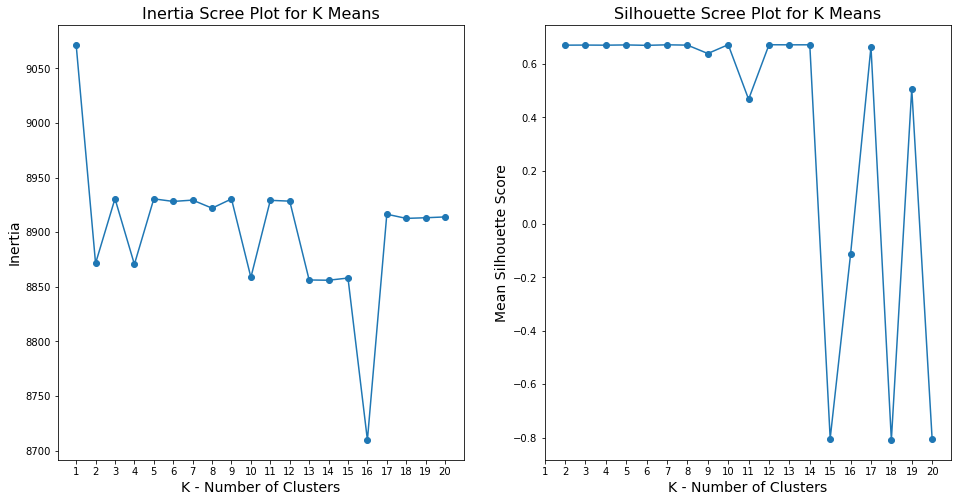

In [11]:
# visualize

plt.subplots(1, 2, figsize=(16, 8))
plt.subplot(1, 2, 1)
metrics_df['inertia'].plot(marker='o')
plt.title('Inertia Scree Plot for K Means', size = 16)
plt.xticks(ks)
plt.ylabel('Inertia', size = 14)
plt.xlabel('K - Number of Clusters', size = 14)
plt.subplot(1, 2, 2)
metrics_df['silhouette'].plot(marker='o')
plt.title('Silhouette Scree Plot for K Means', size = 16)
plt.ylabel('Mean Silhouette Score', size = 14)
plt.xlabel('K - Number of Clusters', size = 14)
plt.xticks(ks)
plt.show()

Because we want to minimize inertia while maximizing the silhouette score, we should select the number of clusters at the "elbow" of the inertia score scree plot that also corresponds to a higher point in the silhouette scree plot. Based on the plots above, there isn't a very clear elbow in our inertia scree plot, but we see that the silhouette score is highest between 1 to 10 clusters, drops slightly at 12, then becomes erratic after `n_clusters=14`. Let's take a look at the cluster sizes to see if we can get a better idea of which `K` to select.

In [21]:
# range of Ks to search over
ks = np.arange(1, 15)

# iterating over ks
for k in ks:
    
    # instantiate
    kmm = KMeans(n_clusters=k)

    # fit on the whole dataset
    kmm.fit(sample_text_pca)
    
    # get cluster labels 
    kmm_labels = kmm.predict(sample_text_pca)
    
    # get cluster size
    size = np.unique(kmm_labels, return_counts=True)
    
    print(size)

(array([0], dtype=int32), array([44506]))
(array([0, 1], dtype=int32), array([34655,  9851]))
(array([0, 1, 2], dtype=int32), array([34702,  2560,  7244]))
(array([0, 1, 2, 3], dtype=int32), array([34702,  7242,  2561,     1]))
(array([0, 1, 2, 3, 4], dtype=int32), array([ 4364,  2063, 33917,  3543,   619]))
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([33922,  4500,  1948,   190,  3825,   121]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([ 3810, 33902,     2,  2023,   906,  3859,     4]))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([33906,  3190,  2119,  3217,     1,    60,    62,  1951]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([33902,  2317,     1,    14,    94,  1926,  3087,    52,  3113]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([33937,    52,    95,  4031,     1,    20,     1,     1,  2102,
        4266]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([33877,  2724,     1,  1705,     1,  1789,  2300, 

We can see that the cluster sizes are quite uneven, with many including clusters of only 1 or 2. With a 3 clusters, the sizes are slightly better, and with `n_clusters=3`, inertia is relatively low and the silhouette score is high. Therefore, I will use `n_clusters=3` for my K-Means model, which will be fit to the PCA-transformed data.

---

### Model v.01

In [22]:
# fit K Means (3 clusters)
# instantiate
kmm_batch = KMeans(n_clusters = 3)

# fit 
kmm_batch.fit(sample_text_pca)

# get cluster labels
kmm_labels_batch = kmm_batch.predict(sample_text_pca)

I can check the cluster size for our K-Means model.

In [23]:
# check cluster size
np.unique(kmm_labels_batch, return_counts=True)

(array([0, 1, 2], dtype=int32), array([34701,  7244,  2561]))

We can see that the the three cluster sizes are 34,701 for cluster 1, 7,244 for cluster 2, and 2,561 for cluster 3. It should be noted that there isn't a hierarchy with the cluster labels and it doesn't make a difference which cluster the data points belong to, just that they are in the different clusters.

#### Clusters 

I can now add the cluster labels back to our original dataset to see which cluster each feature belongs to. Because I am adding a column to the data, I will make a copy of the original dataframe first and then creating a new dataframe with the clusters as the categories and the original columns as the rows.

In [24]:
# create copy of original data
sample_text_copy = sample_text.copy()

# add `clusters` column
sample_text_copy['clusters'] = kmm_labels_batch

# create dataframe by grouping clusters and getting means of each column
text_clusters_df = sample_text_copy.groupby('clusters').mean()

# check
text_clusters_df.head()

,aaroma,abbey,able,abound,abrasive,absent,absolute,absolutely,absurd,abundance,abundant,abv.1,abyss,accent,accented,accentuate,acceptable,access,accessible,accompanied,accompany,accompanying,according,account,acetic,achieve,acid,acidic,acidity,acquired,acre,acrid,across,act,action,active,actual,actually,adam,add,added,adding,addition,additional,additive,adequate,adequately,adjunct,admit,admittedly,advertised,advocate,affair,affordable,aforementioned,afternoon,aftertaste,afterthought,afterwards,age,aged,aggressive,aggressively,aging,ago,agree,ah,ahead,ahh,aid,aint,aipa,aipas,air,airy,akin,albeit,alchemist,alcohol,alcoholic,ale,alive,allagash,allaround,allow,allowed,allowing,allows,allspice,almond,almost,alone,along,alongside,alot,alpha,alpine,already,alright,also,...,whoa,whole,wicked,wide,width,wife,wild,wildflower,willi,willing,win,window,wine,winelike,winey,wing,winner,winter,wisconsin,wise,wish,wisp,wispy,wit,witbier,within,without,wonder,wonderful,wonderfully,wondering,wont,won’t,wood,woodiness,woodsy,woody,woodychandler,word,work,worked,working,world,worldclass,worried,worse,worst,worth,worthy,would,wouldnt,wouldn’t,wouldve,wow,wrap,wrapped,write,writing,written,wrong,x,ya,yarchives,yard,yeah,year.1,yeast,yeastiness,yeastoak,yeasty,yellow,yellowgold,yellowish,yelloworange,yep,yes,yesterday,yet,yield,yielded,ymmv,yogurt,york,youd,youll,young,youre,youve,you’re,yuengling,yum,yummy,yuzu,zero,zest,zesty,zing,zip,zippy,zone
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000025,0.000064,0.00000,0.000000,0.000000,0.000028,0.000151,0.000000,0.000000,0.000000,0.000305,0.000022,0.000042,0.000000,0.000006,0.000005,0.000028,0.000018,0.000000,0.000018,0.000000,0.000011,0.000018,0.000000,0.000000,0.000018,0.000011,0.000016,0.000000,0.000025,0.000000,0.000050,0.000000,0.000009,0.000000,0.000035,0.000121,0.000045,0.000092,0.000035,0.000007,0.000068,0.000023,0.000005,0.000007,0.000000,0.000041,0.000016,0.000017,0.000033,0.000019,0.000009,0.000015,0.000000,0.000039,0.000131,0.000000,0.000012,0.000060,0.000224,0.000024,0.000009,0.000082,0.000115,0.000049,0.000000,0.000018,0.000000,0.000009,0.000023,0.000014,0.000012,0.000000,0.000006,0.000004,0.000013,0.000010,0.000197,0.000036,0.000570,0.000000,0.000011,0.000018,0.000005,0.000018,0.000000,0.000020,0.000007,0.000025,0.000163,0.000041,0.000025,0.000010,0.000014,0.000000,0.000014,0.000051,0.000031,0.000148,...,0.000000,0.000085,0.000044,0.000021,0.000000,0.000115,0.000052,0.000000,0.000000,0.000019,0.000029,0.000006,0.000157,0.000005,0.000000,0.000035,0.000039,0.000115,0.000034,0.000014,0.000152,0.000007,0.000000,0.000028,0.000016,0.000040,0.000164,0.000024,0.000111,0.000057,0.000000,0.000101,0.000039,0.000068,0.000000,0.000000,0.000021,0.000000,0.000080,0.000128,0.000024,0.000000,0.000131,0.000022,0.000006,0.000039,0.000130,0.000223,0.000211,0.000563,0.000119,0.000029,0.000020,0.000253,0.000000,0.000000,0.000048,0.000007,0.000006,0.000070,0.000023,0.000012,0.000000,0.000007,0.000052,0.000429,0.000090,0.000000,0.000000,0.000061,0.000031,0.000000,0.000000,0.000000,0.000024,0.000039,0.000017,0.000188,0.000004,0.000000,0.000000,0.000006,0.000020,0.000064,0.000047,0.000017,0.000078,0.000037,0.000026,0.000039,0.000065,0.000085,0.000018,0.000013,0.000029,0.000005,0.000000,0.000014,0.000000,0.000000
1,0.000704,0.000188,0.000974,0.00036,0.000349,0.000332,0.000504,0.001646,0.000091,0.000424,0.000736,0.009868,0.000034,0.000905,0.000166,0.000154,0.000370,0.000254,0.000181,0.000297,0.000148,0.000171,0.000290,0.000235,0.000484,0.000140,0.001129,0.003145,0.003165,0.000385,0.000361,0.000158,0.002212,0.000264,0.000428,0.001221,0.000437,0.003252,0.000652,0.003233,0.001722,0.000645,0.001787,0.000528,0.000149,0.000780,0.000402,0.001190,0.000380,0.000088,0.001048,0.000265,0.000124,0.000185,0.000425,0.000484,0.008527,0.000181,0.000319,0.001

We can visualize the top 20 features for each cluster for easier interpretation.

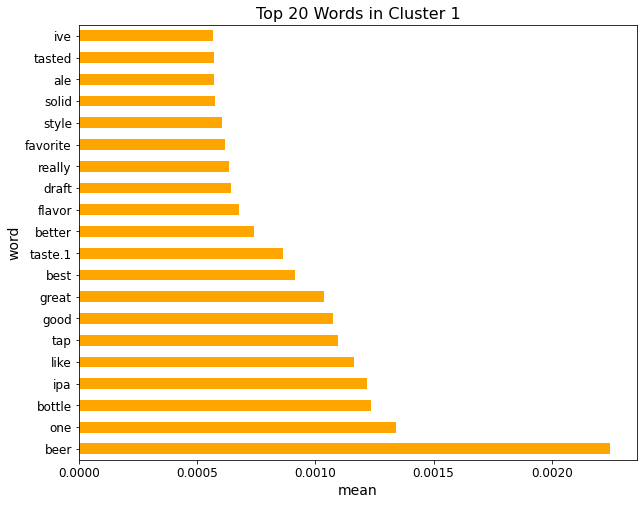

In [27]:
# get top 20 features for cluster 1
cluster_1 = text_clusters_df.T.sort_values(0, ascending = False).head(20)

# visualize
plt.figure(figsize=(10, 8))
cluster_1[0].plot(kind='barh', color='orange')
plt.xlabel('mean', size=14)
plt.ylabel('word', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 20 Words in Cluster 1', size=16)
plt.show()

We can see that "beer" is the top word for cluster 1, which should probably be removed to get better insights. I will repeat the process for the remaining 2 clusters.

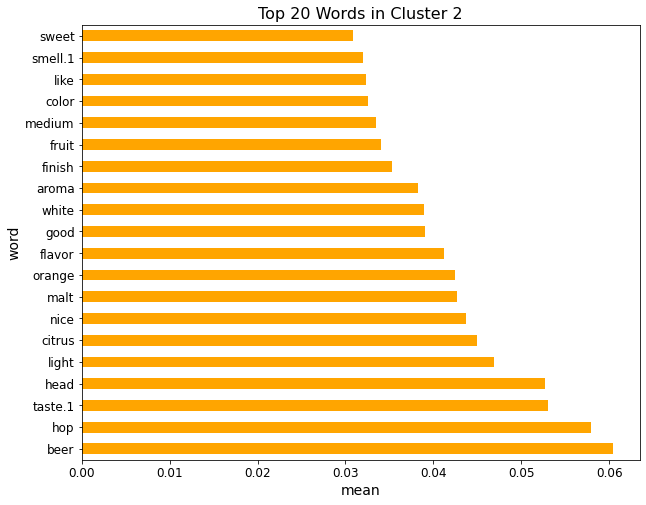

In [28]:
# get top 20 features for cluster 2
cluster_2 = text_clusters_df.T.sort_values(1, ascending = False).head(20)

# visualize
plt.figure(figsize=(10, 8))
cluster_2[1].plot(kind='barh', color='orange')
plt.xlabel('mean', size=14)
plt.ylabel('word', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 20 Words in Cluster 2', size=16)
plt.show()

"Beer" is also the top word for cluster 2. Let's look at the final cluster.

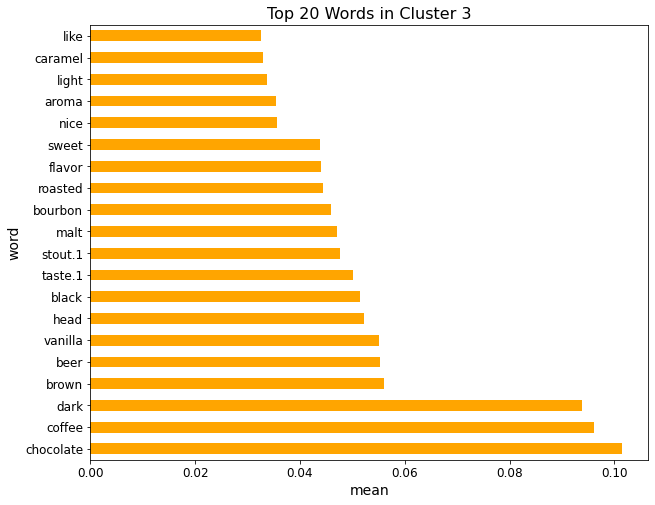

In [29]:
# get top 20 features for cluster 3
cluster_3 = text_clusters_df.T.sort_values(2, ascending = False).head(20)

# visualize
plt.figure(figsize=(10, 8))
cluster_3[2].plot(kind='barh', color='orange')
plt.xlabel('mean', size=14)
plt.ylabel('word', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 20 Words in Cluster 3', size=16)
plt.show()

Although "beer" isn't the top word for cluster 3, it still appears on the list. Let's remove "beer" from our dataset and repeat the whole process again. I'll make a copy of our original dataset.

---

### Model v.02

In [30]:
# create copy of data
sample_text_2 = sample_text.copy()

# check
sample_text_2.head()

,aaroma,abbey,able,abound,abrasive,absent,absolute,absolutely,absurd,abundance,abundant,abv.1,abyss,accent,accented,accentuate,acceptable,access,accessible,accompanied,accompany,accompanying,according,account,acetic,achieve,acid,acidic,acidity,acquired,acre,acrid,across,act,action,active,actual,actually,adam,add,added,adding,addition,additional,additive,adequate,adequately,adjunct,admit,admittedly,advertised,advocate,affair,affordable,aforementioned,afternoon,aftertaste,afterthought,afterwards,age,aged,aggressive,aggressively,aging,ago,agree,ah,ahead,ahh,aid,aint,aipa,aipas,air,airy,akin,albeit,alchemist,alcohol,alcoholic,ale,alive,allagash,allaround,allow,allowed,allowing,allows,allspice,almond,almost,alone,along,alongside,alot,alpha,alpine,already,alright,also,...,whoa,whole,wicked,wide,width,wife,wild,wildflower,willi,willing,win,window,wine,winelike,winey,wing,winner,winter,wisconsin,wise,wish,wisp,wispy,wit,witbier,within,without,wonder,wonderful,wonderfully,wondering,wont,won’t,wood,woodiness,woodsy,woody,woodychandler,word,work,worked,working,world,worldclass,worried,worse,worst,worth,worthy,would,wouldnt,wouldn’t,wouldve,wow,wrap,wrapped,write,writing,written,wrong,x,ya,yarchives,yard,yeah,year.1,yeast,yeastiness,yeastoak,yeasty,yellow,yellowgold,yellowish,yelloworange,yep,yes,yesterday,yet,yield,yielded,ymmv,yogurt,york,youd,youll,young,youre,youve,you’re,yuengling,yum,yummy,yuzu,zero,zest,zesty,zing,zip,zippy,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Recall that our original dataset had 3,647 columns. I will now remove the `beer` column, so we should end up with 3,646 columns.

In [31]:
# remove `beer` column
sample_text_2 = sample_text_2.drop(columns = 'beer')

# check
sample_text_2.shape

(44506, 3646)

The `beer` column was succesfully dropped. I will do PCA with `n_components=0.8` on this dataset like before.

In [32]:
# instantiate PCA with `n_components=0.8` (keep 80% variance)
my_pca = PCA(n_components=0.8)

# fit and transform 
sample_text_2_pca = my_pca.fit_transform(sample_text_2)

# get number of optimal PCs
sample_text_2_pca.shape

(44506, 925)

The number of PCs for the updated dataset is 925. I can fit a K-Means model with `n_clusters=3` again like in model v.01.

In [33]:
# fit K Means (3 clusters)
# instantiate
kmm_2 = KMeans(n_clusters=3)

# fit 
kmm_2.fit(sample_text_2_pca)

# get cluster labels
kmm_2_labels = kmm_2.predict(sample_text_2_pca)

In [34]:
# look at cluster sizing

np.unique(kmm_2_labels, return_counts=True)

(array([0, 1, 2], dtype=int32), array([34955,  6985,  2566]))

Our new cluster sizes are 35,955 for cluster 1, 6,985 for cluster 2, and 2,566 for cluster 3. Let's make a copy of `sample_text_2` and add the `cluster` label column.

In [35]:
# create copy of dataframe
sample_text_2_copy = sample_text_2.copy()

# add clusters column
sample_text_2_copy['clusters'] = kmm_2_labels

I can now create a new dataframe with just the clusters and the original columns.

In [36]:
# create dataframe by grouping clusters and getting means of each column
text_clusters_2 = sample_text_2_copy.groupby('clusters').mean()

# check
text_clusters_2.head()

,aaroma,abbey,able,abound,abrasive,absent,absolute,absolutely,absurd,abundance,abundant,abv.1,abyss,accent,accented,accentuate,acceptable,access,accessible,accompanied,accompany,accompanying,according,account,acetic,achieve,acid,acidic,acidity,acquired,acre,acrid,across,act,action,active,actual,actually,adam,add,added,adding,addition,additional,additive,adequate,adequately,adjunct,admit,admittedly,advertised,advocate,affair,affordable,aforementioned,afternoon,aftertaste,afterthought,afterwards,age,aged,aggressive,aggressively,aging,ago,agree,ah,ahead,ahh,aid,aint,aipa,aipas,air,airy,akin,albeit,alchemist,alcohol,alcoholic,ale,alive,allagash,allaround,allow,allowed,allowing,allows,allspice,almond,almost,alone,along,alongside,alot,alpha,alpine,already,alright,also,...,whoa,whole,wicked,wide,width,wife,wild,wildflower,willi,willing,win,window,wine,winelike,winey,wing,winner,winter,wisconsin,wise,wish,wisp,wispy,wit,witbier,within,without,wonder,wonderful,wonderfully,wondering,wont,won’t,wood,woodiness,woodsy,woody,woodychandler,word,work,worked,working,world,worldclass,worried,worse,worst,worth,worthy,would,wouldnt,wouldn’t,wouldve,wow,wrap,wrapped,write,writing,written,wrong,x,ya,yarchives,yard,yeah,year.1,yeast,yeastiness,yeastoak,yeasty,yellow,yellowgold,yellowish,yelloworange,yep,yes,yesterday,yet,yield,yielded,ymmv,yogurt,york,youd,youll,young,youre,youve,you’re,yuengling,yum,yummy,yuzu,zero,zest,zesty,zing,zip,zippy,zone
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00000,0.000031,0.000071,0.000000,0.000000,0.000000,0.000041,0.000204,0.000000,0.000000,0.000005,0.000407,0.000021,0.000042,0.000000,0.000006,0.000007,0.000034,0.000018,0.000000,0.000018,0.000000,0.000017,0.000031,0.000000,0.000000,0.000021,0.000020,0.000030,0.000000,0.000043,0.000000,0.000075,0.000000,0.000009,0.000000,0.000052,0.000133,0.000045,0.000116,0.000045,0.000007,0.000100,0.000023,0.000005,0.000007,0.000000,0.000068,0.000016,0.000017,0.000047,0.000028,0.000009,0.000019,0.000000,0.000038,0.000157,0.000011,0.000012,0.000067,0.000242,0.000029,0.000009,0.000093,0.000130,0.000061,0.000000,0.000018,0.000000,0.000009,0.000027,0.000014,0.000012,0.000000,0.000006,0.000010,0.000019,0.000010,0.000237,0.000048,0.000701,0.000000,0.000014,0.000018,0.000012,0.000028,0.000009,0.000020,0.000007,0.000032,0.000217,0.000047,0.000040,0.000018,0.000013,0.000000,0.000021,0.000065,0.000045,0.000188,...,0.000000,0.000120,0.000049,0.000028,0.000000,0.000126,0.000052,0.000000,0.000000,0.000019,0.000029,0.000006,0.000194,0.000004,0.000006,0.000035,0.000039,0.000159,0.000044,0.000018,0.000175,0.000007,0.000000,0.000043,0.000016,0.000040,0.000195,0.000031,0.000152,0.000066,0.000004,0.000125,0.000044,0.000082,0.000005,0.00000,0.000020,0.000000,0.000091,0.000158,0.000028,0.000015,0.000154,0.000022,0.000012,0.000042,0.000159,0.000259,0.000216,0.000709,0.000142,0.000035,0.000027,0.000264,0.000007,0.000000,0.000054,0.000017,0.000006,0.000080,0.000029,0.000012,0.000000,0.000024,0.000056,0.000476,0.000101,0.000000,0.000000,0.000060,0.000038,0.000000,0.000000,0.000000,0.000024,0.000071,0.000022,0.000210,0.000004,0.000000,0.000000,0.000006,0.000020,0.000075,0.000040,0.000022,0.000118,0.000045,0.000028,0.000038,0.000064,0.000084,0.000018,0.000017,0.000025,0.000005,0.000000,0.000014,0.000000,0.000000
1,0.00073,0.000195,0.000973,0.000373,0.000362,0.000344,0.000431,0.001548,0.000094,0.000440,0.000736,0.009718,0.000035,0.000939,0.000172,0.000160,0.000374,0.000230,0.000187,0.000308,0.000154,0.000177,0.000271,0.000179,0.000502,0.000145,0.001159,0.003240,0.003211,0.000400,0.000285,0.000164,0.002144,0.000274,0.000444,0.001267,0.000379,0.003267,0.000676,0.003267,0.001740,0.000669,0.001753,0.000530,0.000154,0.000809,0.000416,0.001106,0.000394,0.000091,0.000991,0.000229,0.000129,0.000168,0.000430,0.000502,0.008645,0.000135,0.000330,0.0011

#### Clusters 

Like in v.01, we can extract the top 20 features for each cluster using some bar graphs.

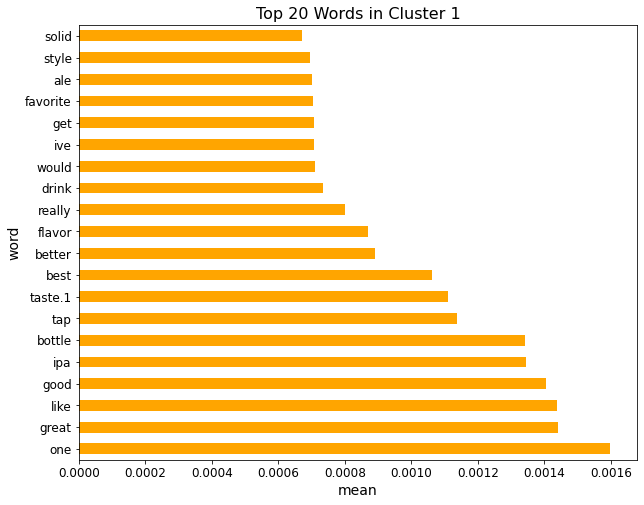

In [37]:
# get top 20 features for cluster 1
v2_cluster_1 = text_clusters_2.T.sort_values(0, ascending = False).head(20)

# visualize
plt.figure(figsize=(10, 8))
v2_cluster_1[0].plot(kind='barh', color='orange')
plt.xlabel('mean', size=14)
plt.ylabel('word', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 20 Words in Cluster 1', size=16)
plt.show()

Looking at cluster 1, we see words that suggest a positive preference, such as "great", "good", "best", "better", "favorite", as well as words that describe how the beer is served, such as "bottle" and "tap", and the beer style, such as "ipa", and "ale." This suggests that IPAs are generally associated with positive sentiment, which supports our earlier EDA where we found IPAs ranking third in average `score` rating.

Let's take a look at cluster 2 now.

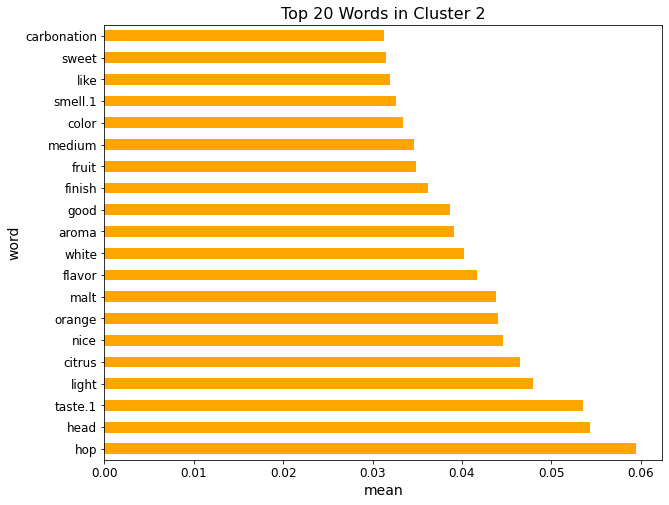

In [38]:
# get top 20 features for cluster 2
v2_cluster_2 = text_clusters_2.T.sort_values(1, ascending = False).head(20)

# visualize
plt.figure(figsize=(10, 8))
v2_cluster_2[1].plot(kind='barh', color='orange')
plt.xlabel('mean', size=14)
plt.ylabel('word', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 20 Words in Cluster 2', size=16)
plt.show()

Looking at cluster 2, we see words that mostly describe the beer flavour, such as "hop", "taste", "light", "citrus", "orange", "malt", and "fruit." Looking at the beer categories, these words align most with Wild/Sour beers, that generally have the characteristics listed here. There are also some sentiment words, such as "nice", "good", and "like." Again, we saw earlier in EDA that the wild/sour beer category had the second highest average `score` rating.

We can look at the final cluster now.

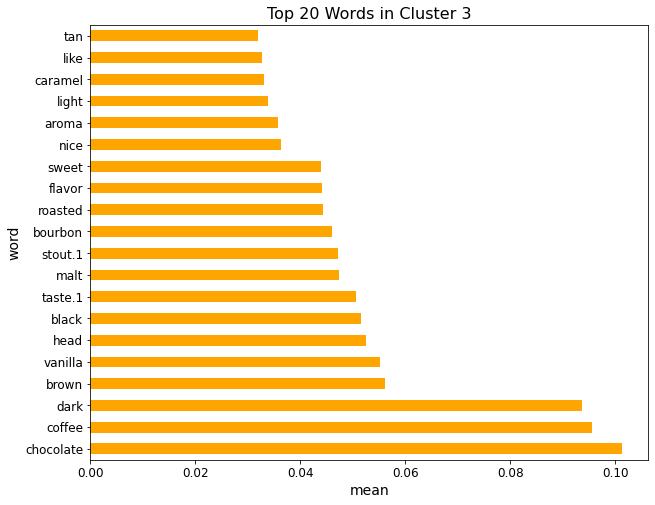

In [48]:
# get top 20 features for cluster 3
v2_cluster_3 = text_clusters_2.T.sort_values(2, ascending=False).head(20)

# visualize
plt.figure(figsize=(10, 8))
v2_cluster_3[2].plot(kind='barh', color='orange')
plt.xlabel('mean', size=14)
plt.ylabel('word', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 20 Words in Cluster 3', size=16)
plt.show()

It is pretty clear that cluster 3 is all about the dark beers, with descriptive words such as "chocolate", "coffee", "dark", "brown", "vanilla", "black", and "bourbon", as well as "stout", which can have all of these characteristics. Stouts had the highest `score` rating in the dataset, so this is fitting.

---

## Summary

Using a K-Means Clustering model with `n_clusters=3`, we got three clusters with the following top features:

| **Cluster 1** | **Cluster 2** | **Cluster 3** | 
| :------ | :---------- | :-------- |
| one     | hop         | chocolate | 
| great   | head        | coffee    |
| like    | taste       | dark      |
| good    | light       | brown     |
| ipa     | citrus      | vanilla   | 
| bottle  | nice        | head      |
| tap     | orange      | black     |
| taste   | malt        | taste     | 
| best    | flavor      | malt      |
| better  | white       | stout     |
| flavor  | aroma       | bourbon   | 
| really  | good        | roasted   |
| drink   | finish      | flavor    | 
| would   | fruit       | sweet     | 
| I've    | medium      | nice      |
| get     | color       | aroma     |
| favorite| smell       | light     | 
| ale     | like        | caramel   |
| style   | sweet       | like      |
| solid   | carbonation | tan       |

We can see that cluster 1 consists of highly positive words used to describe reviewerss experiences as well as the beer styles "IPA" and "ale." Cluster 2 consists of descriptive words that are characteristic of "wild/sour" beers and also positive sentiment. Lastly, cluster 3 consists of words that characterize dark beers, specifically stouts, and have positive sentiment as well.

Using this model can be beneficial for brewers as it tells us what people like or care about. Brewers can use this information to craft beers that will more likely receive higher ratings and it would be interesting to compare the results for different time periods to see any changes in trends.

## Project Next Steps 

The models used in this project have produced some interesting insights, but it is just the first step. Going forward, here are some next steps to attempt:

- Use the full dataset rather than a sample through cloud computing or other methods that allow for higher computational power.
- Use GridSearchCV on the Logistic Regression model to see if the model performance can be improved. I would do the same on the XGBoost model to see if it can outperform the Logistic Regression model.
- Clean up the text review vectorization, as there were some words that still had periods and symbols in them.
- Try other clustering methods, such as DBSCAN.
- Use other machine learning techniques, such as content-based filtering, to build a recommender system that can suggest beers to users based on the users' preferences.